## Climate indicator comparisons

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
from scipy.stats import t as student_t
from statsmodels.tsa.stattools import acf
import matplotlib.lines as mlines

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [3]:
obs = pd.read_csv(IOPATH)
obs

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                       time  \
0                   0             0           0  1933-07-25 00:00:00+00:00   
1                   1             1           1  1933-07-25 00:00:00+00:00   
2                   2             2           2  1933-07-25 00:00:00+00:00   
3                   3             3           3  1933-07-25 00:00:00+00:00   
4                   4             4           4  1933-07-25 00:00:00+00:00   
...               ...           ...         ...                        ...   
1722329       1722329       1722329     1805040  2024-11-18 00:00:00+00:00   
1722330       1722330       1722330     1805041  2024-11-18 00:00:00+00:00   
1722331       1722331       1722331     1805042  2024-11-18 00:00:00+00:00   
1722332       1722332       1722332     1805043  2024-11-18 00:00:00+00:00   
1722333       1722333       1722333     1805044  2024-11-18 00:00:00+00:00   

         longitude (degrees_east)  latitude (degrees_north)  depth (m)  \
0                         -126.76                     49.34        1.0   
1                         -126.76                     49.34        2.0   
2                         -126.76                     49.34        4.0   
3                         -126.76                     49.34        6.0   
4                         -126.76                     49.34       10.0   
...                           ...                       ...        ...   
1722329                   -124.95                     44.38        0.0   
1722330                   -124.94                     44.36        0.0   
1722331                   -124.57                     46.99        0.0   
1722332                   -124.56                     46.99        0.0   
1722333                   -124.31                     44.64        0.0   

         pressure (dbar)  temperature (degC)  salinity (g kg-1)  ...  \
0               1.008587                 NaN          32.070847  ...   
1               2.017180                 NaN          32.090943  ...   
2               4.034378                 NaN          32.090906  ...   
3               6.051598                 NaN          32.090870  ...   
4              10.086095                 NaN          32.181305  ...   
...                  ...                 ...                ...  ...   
1722329         0.000000           12.713836          32.386146  ...   
1722330         0.000000           12.712860          32.386131  ...   
1722331         0.000000           10.586080          32.728763  ...   
1722332         0.000000           12.215222          32.245641  ...   
1722333         0.000000           11.112893          32.193448  ...   

         Ni (nmol kg-1)  Zn (nmol kg-1)      source  current  location  \
0                   NaN             NaN  ios bottle    shelf     shelf   
1                   NaN             NaN  ios bottle    shelf     shelf   
2                   NaN             NaN  ios bottle    shelf     shelf   
3                   NaN             NaN  ios bottle    shelf     shelf   
4                   NaN             NaN  ios bottle    shelf     shelf   
...                 ...             ...         ...      ...       ...   
1722329             NaN             NaN         ooi      NaN     slope   
1722330             NaN             NaN         ooi      NaN     slope   
1722331             NaN             NaN         ooi    shelf     shelf   
1722332             NaN             NaN         ooi    shelf     shelf   
1722333             NaN             NaN         ooi    shelf     shelf   

         [TA-DIC] (uM)  year  month      NSdist  EWdist  
0                  NaN  1933      7 -158.177943    -0.0  
1                  NaN  1933      7 -158.177943    -0.0  
2                  NaN  1933      7 -158.177943    -0.0  
3                  NaN  1933      7 -158.177943    -0.0  
4                  NaN  1933      7 -158.177943    -0.0  
...                ...   ...    ...         ...     ...  
1722329            NaN 

In [4]:
pd.unique(obs['current'])

array(['shelf', nan, 'CUC', 'CC'], dtype=object)

In [5]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [6]:
# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

/tmp/ipykernel_3154202/497193821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc['dist'] = obs_cuc.NSdist
/tmp/ipykernel_3154202/497193821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf['dist'] = obs_shelf.NSdist
/tmp/ipykernel_3154202/497193821.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

bifurcation_index.csv
https://github.com/michaelmalick/bifurcation-index?utm_source=chatgpt.com

In [7]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='month', value_name='index') # rearange df into 3x552 instead of 13x46
enso['month'] = enso['month'].astype(int) 
enso = enso.sort_values(['year', 'month']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'month', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/npgo1950.csv', names=['year', 'month', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='month', value_name='index')
pdo['month'] = pdo['month'].astype(int)
pdo = pdo.sort_values(['year', 'month']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# ------
# BI
# ------
df = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/bifurcation_index.csv",
    header=11,names=["year","index"],
)
bi = pd.DataFrame()
bi['year'] = np.repeat(df.year,12)
bi['month'] = np.tile(np.arange(1,13),len(df.year))
bi['day'] = 1
bi['index'] = np.repeat(df['index'],12)
bi['time'] = pd.to_datetime(bi[['year', 'month', 'day']])

start_of_year = pd.to_datetime(bi['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((bi['year'] + 1).astype(str) + "-01-01")
bi['decimal_yr'] = bi['year'] + (
    (bi['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

## Functions

In [11]:
# ---------- helpers ----------
def _ensure_numeric(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def detrend_linear(s: pd.Series) -> pd.Series:
    """
    Remove a linear trend from a monthly series.
    Returns residuals with same index.
    """
    s = s.dropna().sort_index()
    if len(s) < 3:
        return s * np.nan

    x = np.arange(len(s), dtype=float)
    y = s.to_numpy(dtype=float)
    m, b = np.polyfit(x, y, 1)
    return pd.Series(y - (m*x + b), index=s.index)

# ---------- statistics ----------
def ACF_lag(value,time,*,runningmean=False,useconf=True):
    # calculate the autocorrelation timescale
    # value as array, time as df series

    if runningmean==True: # setting default as false for this file!
        value = add_running_mean_12m(value,time)
    s = pd.Series(value, index=time).sort_index().dropna()
    s = detrend_linear(s) 

    # compute ACF
    max_lag_months = 150
    rho = acf(s, nlags=max_lag_months, fft=True)
    lags = np.arange(max_lag_months+1)

    if useconf==True:
        # approximate 95% confidence interval for white noise
        conf = 1.96 / np.sqrt(len(s))
    else:
        conf=0

    # ---- first lag where ACF drops below +conf ----
    below = np.where(rho[:] <= conf)[0]  # indices in rho[1:]
    if below.size == 0:
        k_cross = np.nan
    else:
        k_cross = int(below[0])-1
    
    return k_cross

def _calc_stats_dof(mean_anom, df2, t_month, *, lag_months=0,
                    L_anom_months=np.nan, L_df2_months=np.nan):
    # p-value uses effective DOF.

    df2_series = pd.Series(df2['index'].values, index=df2['decimal_yr'])

    anom_series = pd.Series(mean_anom, index=t_month)
    anom_series = pd.Series(anom_series.values, index=anom_series.index + (lag_months / 12.0))

    df2_aligned = df2_series.reindex(anom_series.index, method='nearest', tolerance=1/52)

    mask = ~df2_aligned.isna() & ~anom_series.isna()
    x = anom_series[mask].values
    y = df2_aligned[mask].values

    out = {}
    out['n'] = int(mask.sum())
    if out['n'] > 2:
        out["r"] = pearsonr(x, y).statistic

        # choose conservative decorrelation lag
        out["L_used"] = np.nanmax([L_anom_months, L_df2_months])

        # if not np.isfinite(L_used) or L_used <= 0:
        #     return out

        out["neff"] = out['n'] / out["L_used"]

        out["pvalue"] = _pvalue_from_r_neff(out["r"], out["neff"])
    else: 
        out['r'] = np.nan
        out['pvalue'] = np.nan
        out["L_used"] = np.nan
        out["neff"] = np.nan

    return out

def find_best_lag_dof(mean_anom, t_month, df2,
                       L_anom_months, L_df2_months,
                       max_lag_months=6):
    r_by_lag, p_by_lag, n_by_lag = [], [], []
    neff_by_lag = []
    L_used_by_lag = []

    for k in range(int(max_lag_months) + 1):
        stats = _calc_stats_dof(
            mean_anom, df2, t_month,
            lag_months=k,
            L_anom_months=L_anom_months,
            L_df2_months=L_df2_months
        )
        r_by_lag.append(stats["r"])
        p_by_lag.append(stats["pvalue"])
        n_by_lag.append(stats["n"])
        neff_by_lag.append(stats["neff"])
        L_used_by_lag.append(stats["L_used"])

    r_arr = np.asarray(r_by_lag, float)
    if np.all(np.isnan(r_arr)): # if there is no correlation (no data) then just give this message:
        return {"best_lag_months": np.nan, "r": np.nan, "pvalue": np.nan, "n": 0,
                "neff": np.nan, "L_used": np.nan}

    kbest = int(np.nanargmax(np.abs(r_arr)))
    return {
        "best_lag_months": kbest,
        "r": r_by_lag[kbest],
        "pvalue": p_by_lag[kbest],
        "n": n_by_lag[kbest],
        "neff": neff_by_lag[kbest],
        "L_used": L_used_by_lag[kbest],
    }

def _pvalue_from_r_neff(r, neff):
    """
    Two-sided p-value for Pearson r using effective sample size neff.
    Returns a scalar p-value (float).
    """
    if not np.isfinite(r) or not np.isfinite(neff):
        return np.nan

    dof = neff - 2
    if dof <= 0:
        return np.nan

    r = np.clip(r, -0.999999, 0.999999)
    tstat = r * np.sqrt(dof / (1 - r**2))
    p = 2 * (1 - student_t.cdf(np.abs(tstat), dof))
    return p

def plot_panel(ax, mean_anom, df2, t_month,L_anom_months, L_df2_months,max_lag_months=6,colour='k',xloc=0,yloc=0.82):
    best = find_best_lag_dof(mean_anom, t_month, df2,
                       L_anom_months, L_df2_months, max_lag_months=max_lag_months)

    statstext = (f"Lag = {best['best_lag_months']} mo, n = {best['n']}\n"
                 f"r = {best['r']:.2f}  (p = {best['pvalue']:.3f}), auto={best['L_used']:.2f}")

    props = dict(boxstyle='round', facecolor='w',edgecolor=colour, alpha=0.7)
    c = ax.text(xloc, yloc, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    return c

# ---------- monthly lat-binned means ----------
def avg_profile_12months_dist(obs_used, dist_edges, variable_str, return_counts=False, usedist=False):
    if usedist==False:
        s = _ensure_numeric(obs_used, [variable_str, 'latitude (degrees_north)', 'month'])
        s = s.dropna(subset=[variable_str, 'latitude (degrees_north)', 'month']).copy()
        s['_zbin'] = pd.cut(s['latitude (degrees_north)'], bins=dist_edges, right=False, include_lowest=True, labels=False)
    else:
        s = _ensure_numeric(obs_used, [variable_str, 'dist', 'month'])
        s = s.dropna(subset=[variable_str, 'dist', 'month']).copy()
        s['_zbin'] = pd.cut(s['dist'], bins=dist_edges, right=False, include_lowest=True, labels=False)
    s['_month'] = s['month'].astype(int)

    # groups by month (obs_used only a year of data)
    g = s.groupby(['_month', '_zbin'])[variable_str].agg(['mean', 'count'])
    nbins = len(dist_edges) - 1
    mean_arr = np.full((12, nbins), np.nan)
    cnt_arr = np.zeros((12, nbins), dtype=int)

    if not g.empty:
        idx = g.index.to_frame(index=False)
        m_ix = idx['_month'].to_numpy() - 1
        z_ix = idx['_zbin'].astype(int).to_numpy()
        mean_arr[m_ix, z_ix] = g['mean'].to_numpy()
        cnt_arr[m_ix, z_ix] = g['count'].to_numpy()

    return (mean_arr, cnt_arr) if return_counts else mean_arr

def contour_prep_dist_monthly(obs_used, start_yr, end_yr, dist_edges,
                               variable_str, base_period=None, min_samples_per_cell=3, usedist=False):
    years = np.arange(int(start_yr), int(end_yr) + 1)
    nyears = len(years)

    # climatology base period
    if base_period is not None:
        by0, by1 = base_period
        clim_obs = obs_used[(obs_used['year'] >= by0) & (obs_used['year'] <= by1)]
    else:
        clim_obs = obs_used

    # to get the mean annual of the base period
    clim_mean = avg_profile_12months_dist(clim_obs, dist_edges,
                                                     variable_str, return_counts=False, usedist=usedist)

    yr_month_means = []
    yr_month_counts = []
    for yr in years:  # loop through avg_profile_12_months_dist for every year you're interested in to get monthly means
        m12, c12 = avg_profile_12months_dist(
            obs_used[obs_used['year'] == yr], dist_edges, variable_str, return_counts=True, usedist=usedist)
        yr_month_means.append(m12)
        yr_month_counts.append(c12)

    # shapes currently (years,12,#bins) want to be (year*months, #bins)
    yr_means = np.vstack(yr_month_means)
    yr_counts = np.vstack(yr_month_counts)

    # anomaly calculation
    clim_tiled = np.tile(clim_mean, (nyears, 1))
    anom = (yr_means - clim_tiled)
    mask = (yr_counts >= min_samples_per_cell) # check that the number of samples to get a monthly mean was at least 3 
    anom[~mask] = np.nan

    months = np.tile(np.arange(1, 13), nyears)
    years_rep = np.repeat(years, 12)
    t_month = years_rep + (months - 1) / 12.0 # t_month at start of month to align with dates we set for climate indices
    return anom.T, t_month.T


## Autocorrelation

ENSO: first lag below conf = 10 months (conf=0.083)
ENSO: first lag below 0 = 11 months
PDO: first lag below conf = 50 months (conf=0.043)
PDO: first lag below 0 = 69 months
NPGO: first lag below conf = 41 months (conf=0.065)
NPGO: first lag below 0 = 49 months
BI: first lag below conf = 14 months (conf=0.074)
BI: first lag below 0 = 54 months


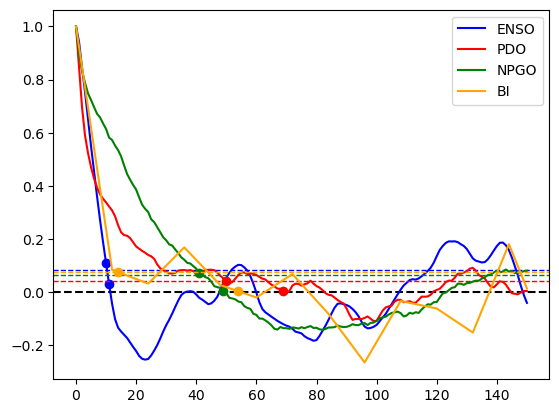

In [12]:
# autocorrelation of the different indices

names = ['ENSO','PDO','NPGO','BI']
indices = [enso,pdo,npgo,bi]
colours = ['b','r','g','orange']

# plot autocorrelation as a function of time
fig, ax = plt.subplots(1,1)
ax.axhline(0,color='k',ls='--')

for i in range(len(indices)):

        value = indices[i]['index'].values
        s = pd.Series(value, index=indices[i].time).sort_index().dropna()
        s = detrend_linear(s) 
        
        # compute ACF
        max_lag_months = 150
        rho = acf(s, nlags=max_lag_months, fft=True)
        lags = np.arange(max_lag_months+1)
        ax.plot(lags,rho,color=colours[i],label=names[i])

        # approximate 95% confidence interval for white noise
        conf = 1.96 / np.sqrt(len(s))
        ax.axhline(conf, color=colours[i],ls='--', lw=1)
        # ax.axhline(-conf, color=colours[i], ls='--', lw=1)

        # ---- first lag where ACF drops below +conf ----
        below = np.where(rho[:] <= conf)[0]  # indices in rho[1:]
        if below.size == 0:
                k_cross = np.nan
                print(f"{names[i]}: ACF does not drop below conf out to {nlags} months (conf={conf:.3f})")
        else:
                k_cross = int(below[0])-1 
                print(f"{names[i]}: first lag below conf = {k_cross} months (conf={conf:.3f})")

                # mark it on the plot
                ax.plot(k_cross, rho[k_cross], marker='o', color=colours[i])
        
        # ---- second lag where ACF drops below 0 ----
        below = np.where(rho[:] <= 0)[0] 
        if below.size == 0:
                k_cross = np.nan
                print(f"{names[i]}: ACF does not drop below 0 out to {nlags} months (conf={conf:.3f})")
        else:
                k_cross = int(below[0])-1
                print(f"{names[i]}: first lag below 0 = {k_cross} months")

                # mark it on the plot
                ax.plot(k_cross, rho[k_cross], marker='o', color=colours[i])
ax.legend()

# Confidence Interval

In [13]:
# running mean already calculated for the indices
Lenso = ACF_lag(enso['index'].values,enso.time,runningmean=False)
Lpdo = ACF_lag(pdo['index'].values,pdo.time,runningmean=False)
Lnpgo = ACF_lag(npgo['index'].values,npgo.time,runningmean=False)
Lbi = ACF_lag(bi['index'].values,bi.time,runningmean=False)

## Tables

In [14]:
def tables(obs_used, dist_edges, *, base_period= (1991, 2020), min_samples_per_cell=3, usedist=False):
# prints out correlation results for each of the variables and indices

    vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']

    for variable_str in vars:
        print(variable_str)
        start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
        end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

        anom_array, t_month = contour_prep_dist_monthly(
            obs_used, start_yr, end_yr, dist_edges,
            variable_str, base_period=base_period, min_samples_per_cell=min_samples_per_cell, usedist=usedist
        )

        regions = ['Southern','Central','Northern']
        for i in range(len(regions)):

            L = ACF_lag(anom_array[i],t_month)

            print(regions[i])
            best = find_best_lag_dof(anom_array[i], t_month, enso, L,Lenso,max_lag_months=6)
            print(f"ENSO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            best = find_best_lag_dof(anom_array[i], t_month, pdo,L,Lpdo, max_lag_months=6)
            print(f"PDO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            best = find_best_lag_dof(anom_array[i], t_month, npgo,L,Lnpgo, max_lag_months=6)
            print(f"NPGO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            best = find_best_lag_dof(anom_array[i], t_month, bi,L,Lbi, max_lag_months=6)
            print(f"BI & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            print("\n")

In [15]:
base_period = (1991, 2020)
obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]

tables(obs_used,dist_edges)

temperature (degC)
Southern
ENSO & 0.40 & 0.063 & 2 & 222
PDO & 0.30 & 0.469 & 0 & 408
NPGO & -0.24 & 0.514 & 4 & 408
BI & -0.12 & 0.614 & 4 & 272


Central
ENSO & 0.31 & 0.219 & 2 & 174
PDO & 0.29 & 0.634 & 1 & 254
NPGO & -0.24 & 0.632 & 6 & 254
BI & -0.03 & 0.907 & 6 & 199


Northern
ENSO & 0.40 & 0.060 & 0 & 349
PDO & 0.33 & 0.469 & 0 & 355
NPGO & -0.22 & 0.591 & 2 & 350
BI & -0.14 & 0.520 & 0 & 350


salinity (g kg-1)
Southern
ENSO & -0.28 & 0.257 & 6 & 224
PDO & -0.15 & 0.713 & 0 & 408
NPGO & 0.09 & 0.799 & 1 & 408
BI & 0.20 & 0.409 & 6 & 273


Central
ENSO & -0.38 & 0.130 & 2 & 174
PDO & -0.26 & 0.660 & 0 & 256
NPGO & 0.23 & 0.649 & 2 & 256
BI & 0.24 & 0.413 & 6 & 199


Northern
ENSO & -0.05 & 0.766 & 0 & 371
PDO & -0.08 & 0.817 & 5 & 526
NPGO & 0.20 & 0.534 & 5 & 502
BI & 0.04 & 0.835 & 2 & 420


spice
Southern
ENSO & 0.34 & 0.123 & 1 & 222
PDO & 0.21 & 0.615 & 0 & 408
NPGO & -0.20 & 0.587 & 4 & 408
BI & -0.06 & 0.811 & 4 & 272


Central
ENSO & 0.18 & 0.492 & 2 & 174
PDO & 0.18 

In [16]:
base_period = (1991, 2020)
obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]

tables(obs_used,dist_edges)

temperature (degC)
Southern
ENSO & 0.15 & 0.511 & 1 & 224
PDO & 0.03 & 0.944 & 3 & 443
NPGO & -0.11 & 0.754 & 4 & 437
BI & 0.09 & 0.688 & 5 & 288


Central
ENSO & -0.05 & 0.852 & 6 & 157
PDO & 0.22 & 0.718 & 0 & 258
NPGO & 0.10 & 0.850 & 0 & 251
BI & 0.06 & 0.858 & 5 & 181


Northern
ENSO & 0.19 & 0.385 & 4 & 269
PDO & 0.08 & 0.880 & 5 & 286
NPGO & -0.27 & 0.573 & 2 & 280
BI & 0.05 & 0.838 & 5 & 271


salinity (g kg-1)
Southern
ENSO & 0.13 & 0.552 & 1 & 224
PDO & 0.02 & 0.963 & 3 & 443
NPGO & -0.11 & 0.764 & 3 & 436
BI & 0.10 & 0.660 & 5 & 288


Central
ENSO & -0.08 & 0.785 & 6 & 157
PDO & 0.22 & 0.716 & 0 & 258
NPGO & 0.09 & 0.869 & 3 & 253
BI & 0.06 & 0.848 & 5 & 181


Northern
ENSO & 0.12 & 0.641 & 4 & 269
PDO & 0.05 & 0.931 & 4 & 287
NPGO & -0.27 & 0.559 & 2 & 280
BI & -0.05 & 0.845 & 0 & 272


spice
Southern
ENSO & 0.14 & 0.523 & 1 & 224
PDO & 0.02 & 0.953 & 3 & 443
NPGO & -0.11 & 0.761 & 4 & 437
BI & 0.10 & 0.678 & 5 & 288


Central
ENSO & -0.06 & 0.822 & 6 & 157
PDO & 0.22 & 0.7

In [17]:
base_period = (1991, 2020)
obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]

tables(obs_used,dist_edges)

temperature (degC)
Southern
ENSO & 0.36 & 0.096 & 1 & 230
PDO & 0.24 & 0.539 & 0 & 453
NPGO & -0.30 & 0.377 & 4 & 447
BI & -0.20 & 0.399 & 0 & 290


Central
ENSO & 0.36 & 0.686 & 2 & 36
PDO & 0.38 & 0.870 & 1 & 121
NPGO & -0.12 & 0.932 & 5 & 117
BI & -0.38 & 0.601 & 5 & 58


Northern
ENSO & 0.14 & 0.512 & 3 & 231
PDO & 0.14 & 0.811 & 6 & 262
NPGO & -0.13 & 0.800 & 4 & 255
BI & 0.08 & 0.765 & 3 & 237


salinity (g kg-1)
Southern
ENSO & -0.22 & 0.318 & 6 & 232
PDO & -0.08 & 0.834 & 6 & 453
NPGO & 0.04 & 0.911 & 6 & 449
BI & 0.09 & 0.685 & 6 & 293


Central
ENSO & 0.30 & 0.740 & 4 & 36
PDO & 0.26 & 0.911 & 4 & 121
NPGO & 0.13 & 0.924 & 5 & 117
BI & 0.25 & 0.743 & 0 & 58


Northern
ENSO & 0.10 & 0.664 & 0 & 231
PDO & 0.09 & 0.877 & 0 & 264
NPGO & 0.27 & 0.590 & 2 & 255
BI & -0.19 & 0.477 & 0 & 237


spice
Southern
ENSO & 0.23 & 0.283 & 1 & 230
PDO & 0.15 & 0.691 & 0 & 453
NPGO & -0.22 & 0.514 & 4 & 447
BI & -0.13 & 0.586 & 1 & 291


Central
ENSO & 0.39 & 0.655 & 2 & 36
PDO & 0.43 & 0.850 &

## Summary Plots

In [18]:
def summary_plot(ax, obs_used, indice, Lindice, dist_edges, *, base_period= (1991, 2020), min_samples_per_cell=3):

    vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
    varmark = ['P','X','o','^','d']

    for i in range(len(vars)):
        start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
        end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

        anom_array, t_month = contour_prep_dist_monthly(
            obs_used, start_yr, end_yr, dist_edges,
            vars[i], base_period=base_period, min_samples_per_cell=min_samples_per_cell
        )

        L = ACF_lag(anom_array[0],t_month)
        best = find_best_lag_dof(anom_array[0], t_month, indice,L,Lindice, max_lag_months=6)
        if best['pvalue'] <= 0.01 and best['n'] >100:
            ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
        
        L = ACF_lag(anom_array[1],t_month)
        best = find_best_lag_dof(anom_array[1], t_month, indice,L,Lindice, max_lag_months=6)
        if best['pvalue'] <= 0.01 and best['n'] >100:
            ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
        
        L = ACF_lag(anom_array[2],t_month)
        best = find_best_lag_dof(anom_array[2], t_month, indice,L,Lindice, max_lag_months=6)
        if best['pvalue'] <= 0.01 and best['n'] >100:
            ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)


<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3154202/1857883325.py:37: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_3154202/1857883325.py:37: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]


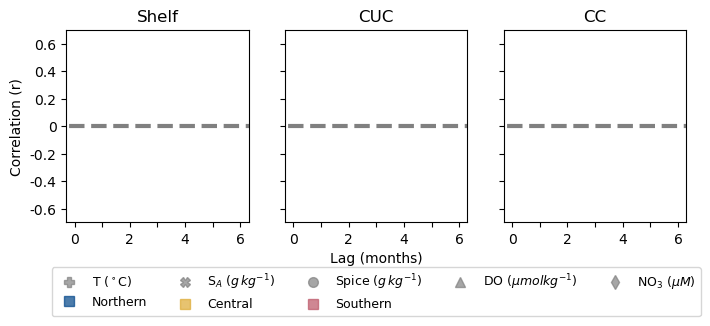

In [19]:
# ENSO
indice= enso
Lindice = Lenso

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, Lindice,dist_edges)


# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3154202/601779331.py:37: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_3154202/601779331.py:37: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/t

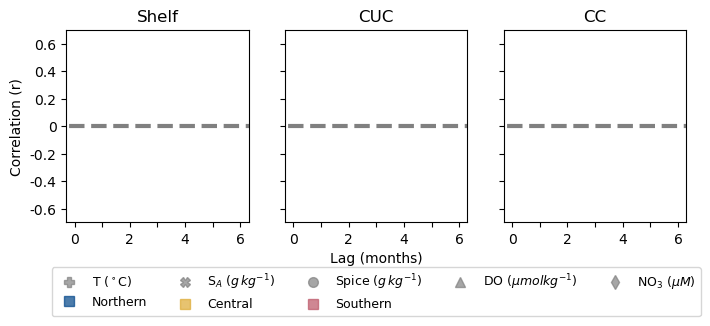

In [20]:
# PDO
indice= pdo
Lindice=Lpdo

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, Lindice,dist_edges)


# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3154202/1814688761.py:37: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_3154202/1814688761.py:37: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]


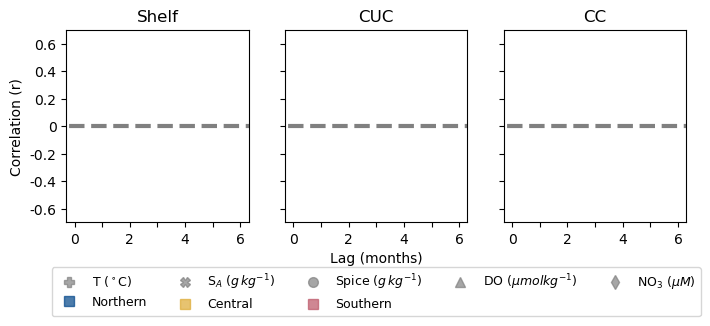

In [21]:
# NPGO
indice= npgo
Lindice = Lnpgo

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, Lindice,dist_edges)


# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3154202/228910991.py:36: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_3154202/228910991.py:36: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/t

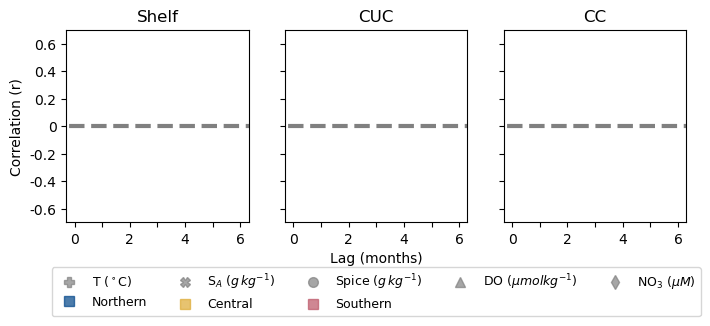

In [22]:
# BI
indice= bi
indices = Lbi

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, Lindice,dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, Lindice,dist_edges)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\,'
<>:90: SyntaxWarning: invalid escape sequence '\,'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\,'
<>:90: SyntaxWarning: invalid escape sequence '\,'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3154202/2631501416.py:90: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'North/West', 'S$_A$ ($g \,kg^{-1}$)', 'South', 'Spice ($g \,kg^{-1}$)','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_3154202/2631501416.py:90: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'North/West', 'S$_A$ ($g \,kg^{-1}$)', 'South', 'Spice ($g \,kg^{-1}$)','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_3154202

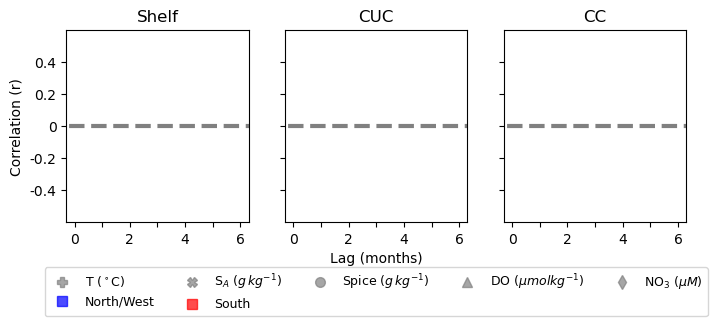

In [23]:
base_period = (1991, 2020)
indice= bi
indices = Lbi

num_obs = 50
vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

dist_edges = [np.min(obs_cc.dist),0,800]

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3,usedist=True
    )

    L = ACF_lag(anom_array[1],t_month)
    best = find_best_lag_dof(anom_array[1], t_month, indice,L,Lindice, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='r',alpha=0.7)
    L = ACF_lag(anom_array[0],t_month)
    best = find_best_lag_dof(anom_array[0], t_month, indice,L,Lindice, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='b',alpha=0.7)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3,usedist=True
    )

    L = ACF_lag(anom_array[1],t_month)
    best = find_best_lag_dof(anom_array[1], t_month, indice,L,Lindice, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='r',alpha=0.7)
    L = ACF_lag(anom_array[0],t_month)
    best = find_best_lag_dof(anom_array[0], t_month, indice,L,Lindice, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='b',alpha=0.7)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3,usedist=True
    )

    L = ACF_lag(anom_array[1],t_month)
    best = find_best_lag_dof(anom_array[1], t_month, indice,L,Lindice, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='r',alpha=0.7)
    L = ACF_lag(anom_array[0],t_month)
    best = find_best_lag_dof(anom_array[0], t_month, indice,L,Lindice, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='b',alpha=0.7)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'North/West', 'S$_A$ ($g \,kg^{-1}$)', 'South', 'Spice ($g \,kg^{-1}$)','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','b','grey','r','grey','grey','grey']
markers = ['P','s','X','s','o','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/BI_CCsplit.png', bbox_inches='tight')

## Latitude Anomaly Plots

In [28]:
def showcorrelation(obs_used,variable_str,vmax,base_period=(1991, 2020)):
    
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
    dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges1,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )

    L0= ACF_lag(anom_array[0],t_month)
    L1= ACF_lag(anom_array[1],t_month)
    L2= ACF_lag(anom_array[2],t_month)

    # ---------- plot ----------
    fig, ax = plt.subplots(5, 1, figsize=(10, 12), constrained_layout=True)

    # --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
    # mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
    indices_name = ['ENSO','PDO','NPGO','BI']
    for i in range(4):
        ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
        ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
        ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
        ax[i].axhline(0, color='k', lw=0.8)
        ax[i].grid(True, alpha=0.3)
        ax[i].set_xlim(start_yr, end_yr + 1)
        ax[i].set_ylabel('NO3 anomaly (uM)')
        ax[i].set_title(f"{variable_str} anomaly versus {indices_name[i]}")

        if i ==0:
            Yind = enso['index']
            Xind = enso['decimal_yr']
            plot_panel(ax[i], anom_array[2], enso,t_month,L2,Lenso,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], anom_array[1], enso,t_month,L1,Lenso,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], anom_array[0], enso,t_month,L0,Lenso,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        elif i ==1:
            Yind = pdo['index']
            Xind = pdo['decimal_yr']
            plot_panel(ax[i], anom_array[2], pdo,t_month,L2,Lpdo,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], anom_array[1], pdo,t_month,L1,Lpdo,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], anom_array[0], pdo,t_month,L0,Lpdo,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        elif i==2:
            Yind = npgo['index']
            Xind = npgo['decimal_yr']
            plot_panel(ax[i], anom_array[2], npgo,t_month,L2,Lnpgo,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], anom_array[1], npgo,t_month,L1,Lnpgo,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], anom_array[0], npgo,t_month,L0,Lnpgo,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        elif i==3:
            Yind = bi['index']
            Xind = bi['decimal_yr']
            plot_panel(ax[i], anom_array[2], bi,t_month,L2,Lbi,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], anom_array[1], bi,t_month,L1,Lbi,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], anom_array[0], bi,t_month,L0,Lbi,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        ax[i].plot(Xind, Yind, color='gray', lw=1)
    ax[0].legend(loc = 'upper right')

    # --- bottom panel: depth–time contour ---
    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges2,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )

    X, Y = np.meshgrid(t_month, dist_edges2[:-1])
    vmax = vmax
    levels = np.linspace(-vmax, vmax, 80)
    cp = ax[4].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
    ax[4].set_xlim(start_yr, end_yr + 1)
    ax[4].set_xlabel('Year')
    ax[4].set_ylabel('Latitude ($^\circ$N)')
    ax[4].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
    ax[4].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
    ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

    cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                        aspect=40, shrink=0.75, ticks=[-vmax, 0,vmax])
    cbar.set_label(f"{variable_str} anomaly")


<>:78: SyntaxWarning: invalid escape sequence '\c'
<>:78: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3154202/323658805.py:78: SyntaxWarning: invalid escape sequence '\c'
  ax[4].set_ylabel('Latitude ($^\circ$N)')


### Temperature

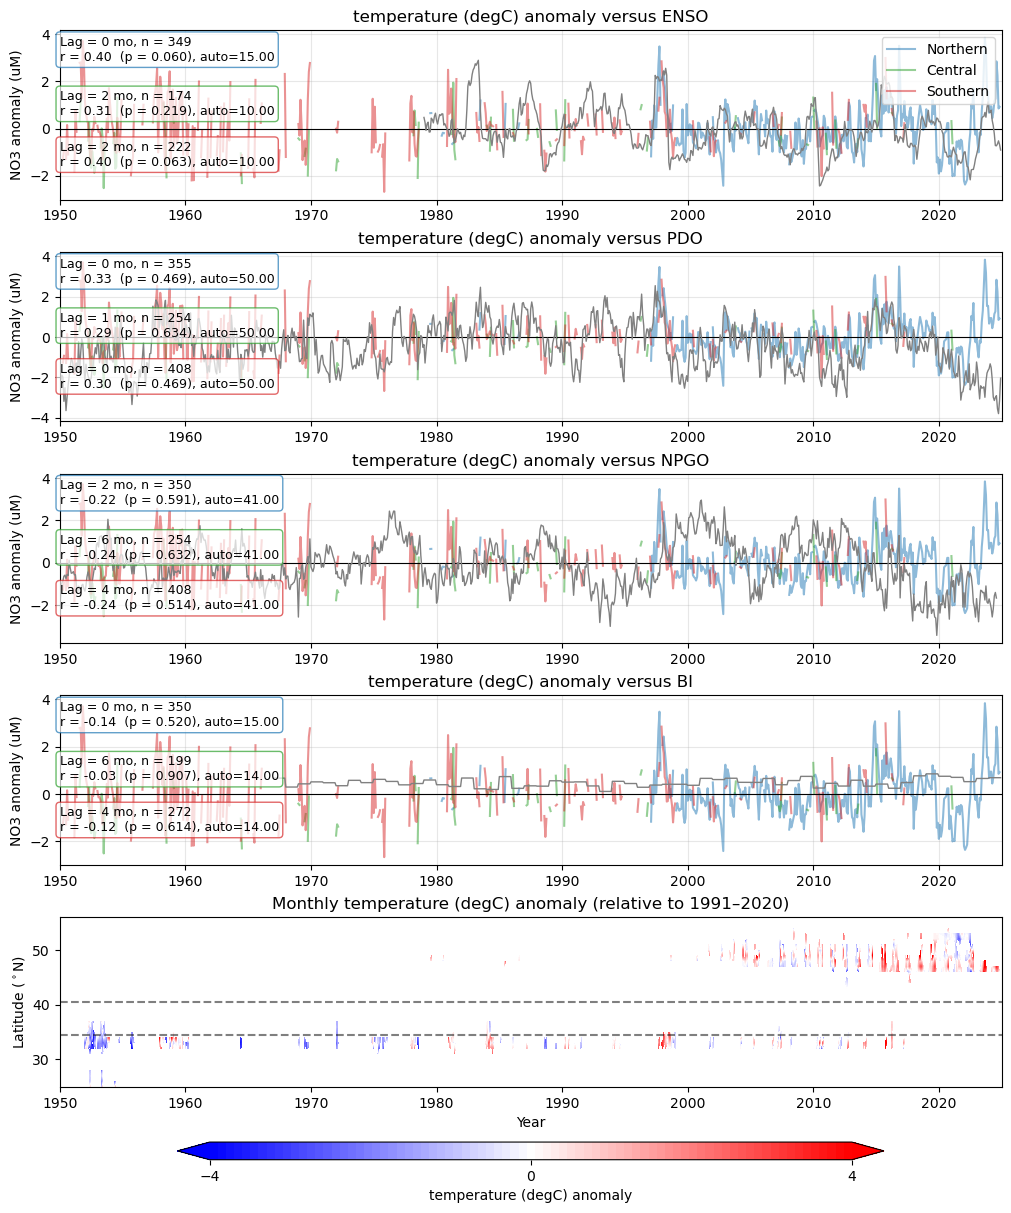

In [29]:
obs_used = obs_shelf.copy()
variable_str = 'temperature (degC)'
showcorrelation(obs_used,variable_str,vmax=4)

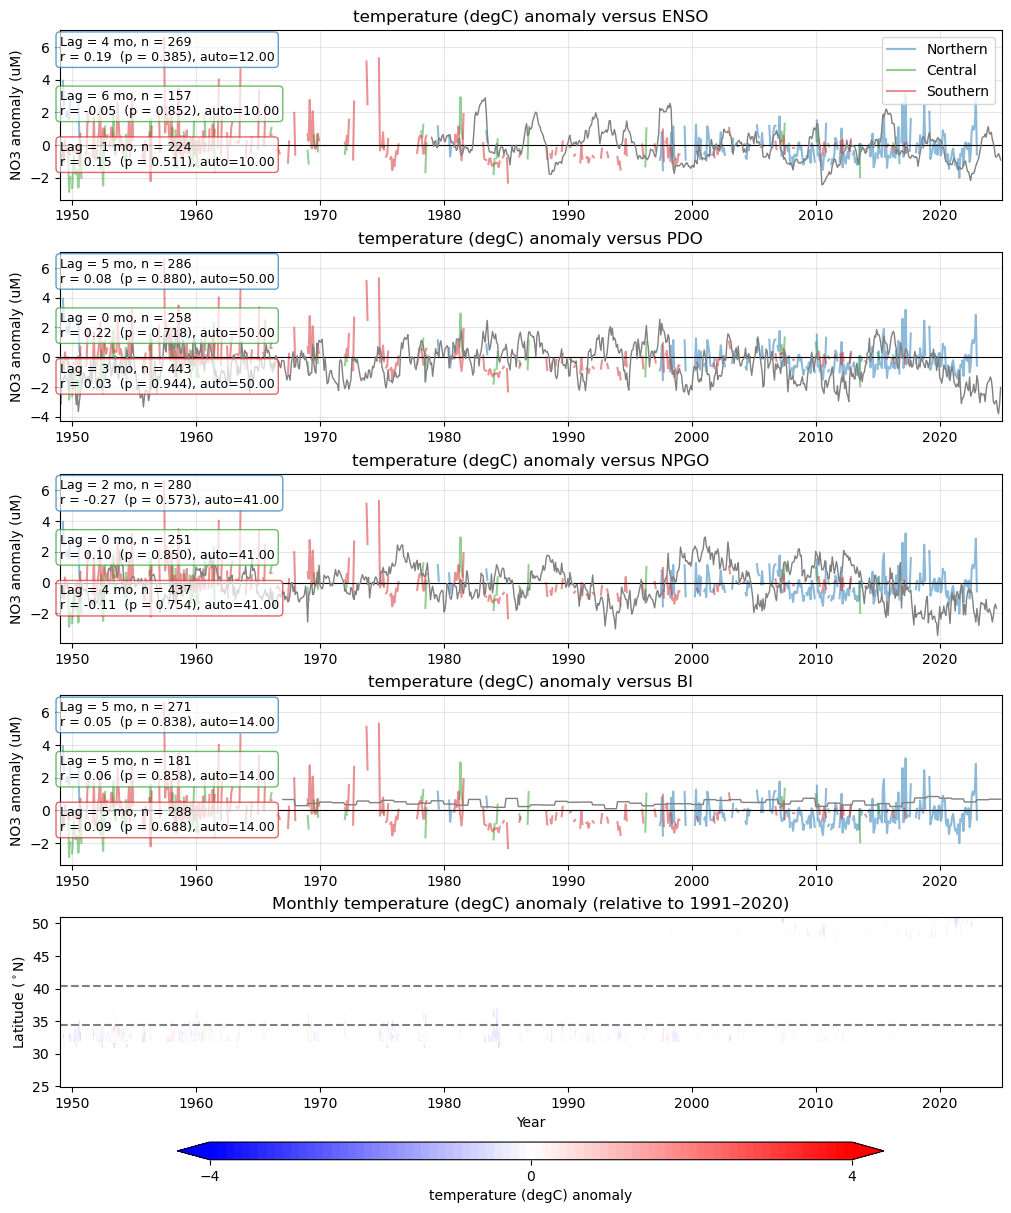

In [30]:
obs_used = obs_cuc.copy()
variable_str = 'temperature (degC)'
showcorrelation(obs_used,variable_str,vmax=4)

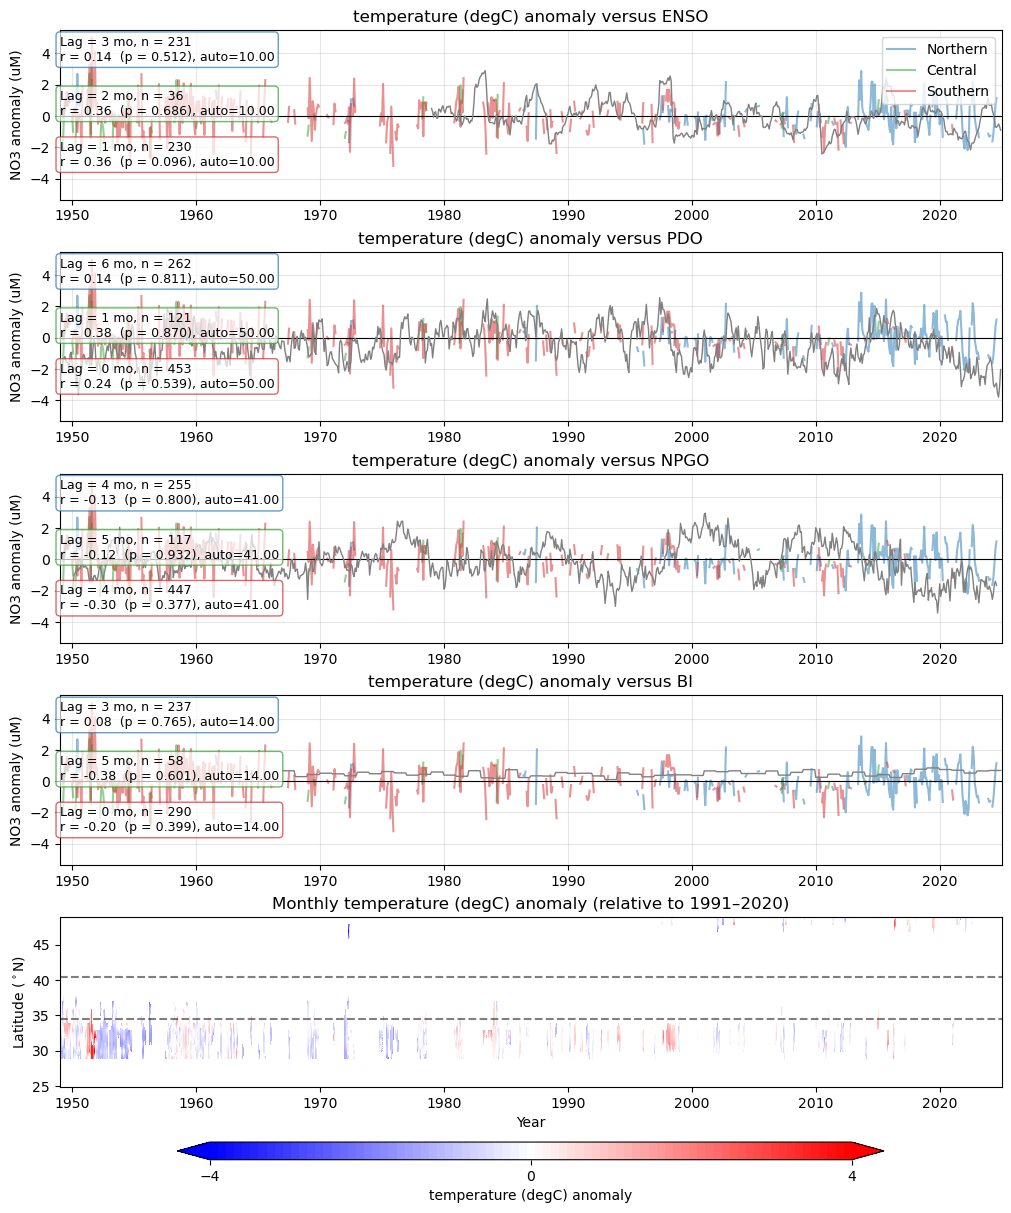

In [31]:
obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'
showcorrelation(obs_used,variable_str,vmax=4)

### Salinity

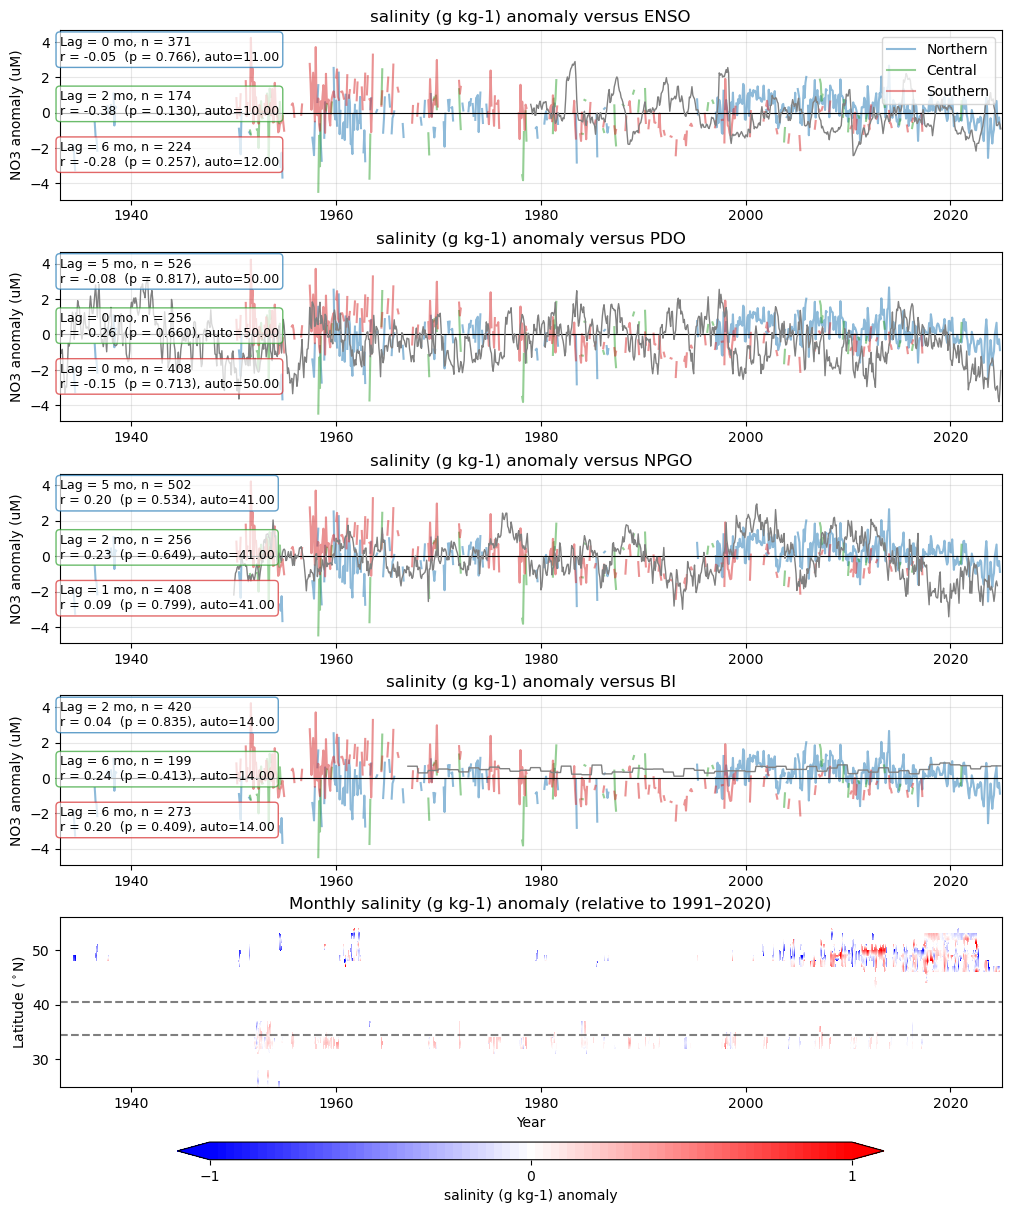

In [32]:
obs_used = obs_shelf.copy()
variable_str = 'salinity (g kg-1)'
showcorrelation(obs_used,variable_str,vmax=1)

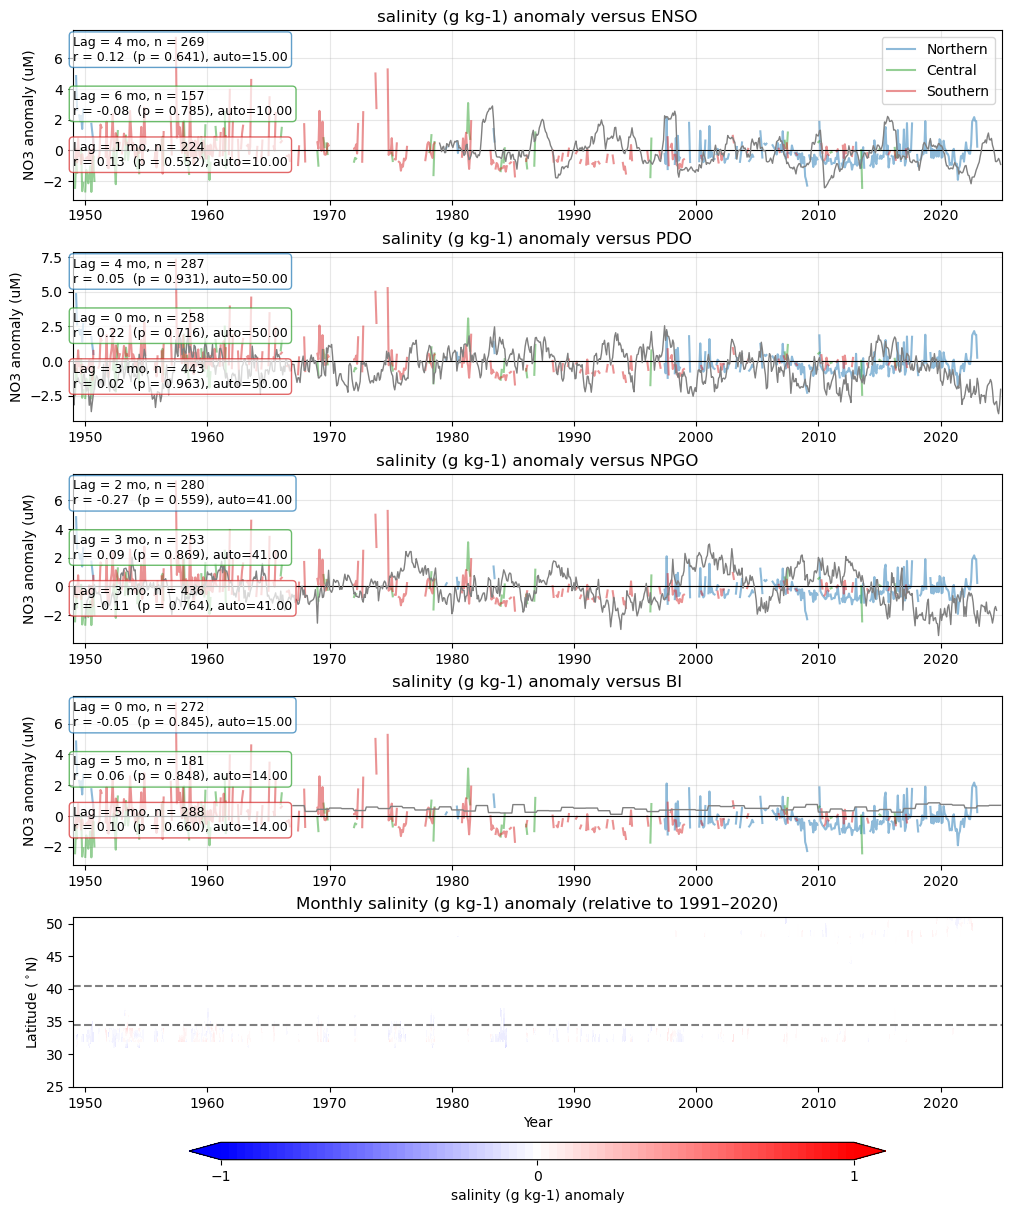

In [33]:
obs_used = obs_cuc.copy()
variable_str = 'salinity (g kg-1)'
showcorrelation(obs_used,variable_str,vmax=1)


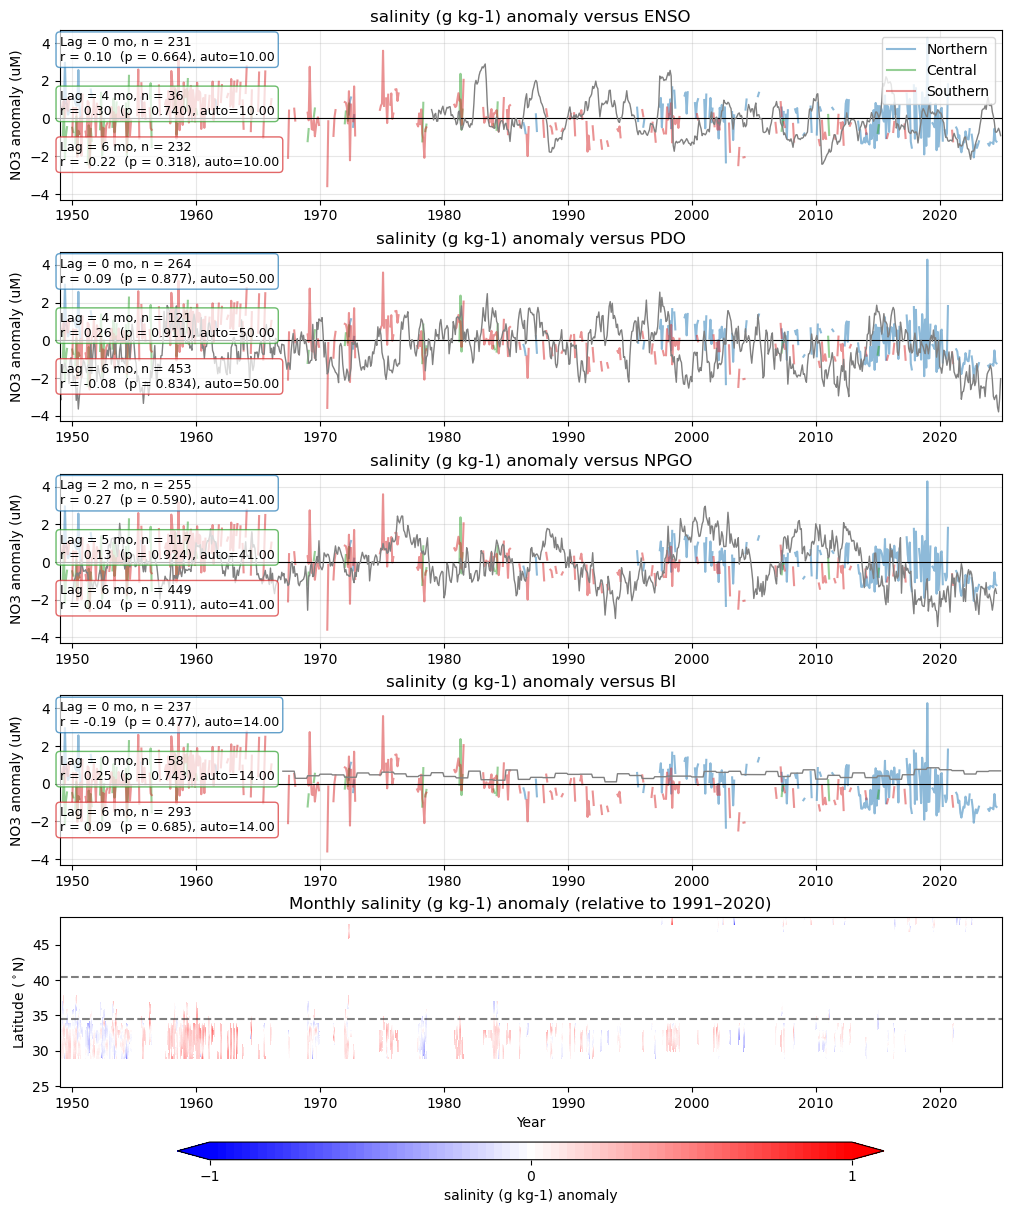

In [34]:
obs_used = obs_cc.copy()
variable_str = 'salinity (g kg-1)'
showcorrelation(obs_used,variable_str,vmax=1)

### DO

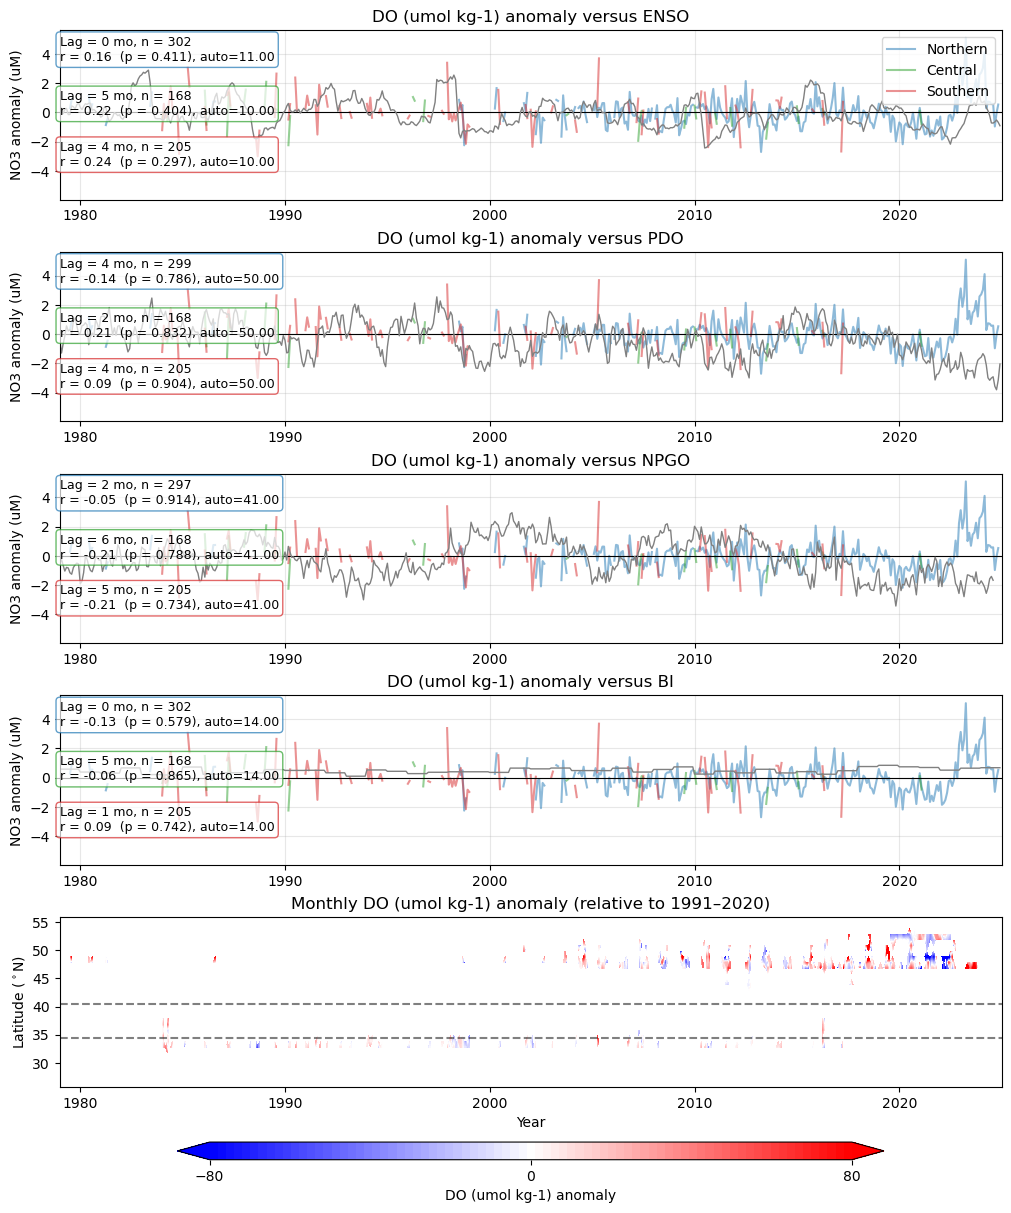

In [35]:
obs_used = obs_shelf.copy()
variable_str = 'DO (umol kg-1)'
showcorrelation(obs_used,variable_str,vmax=80)

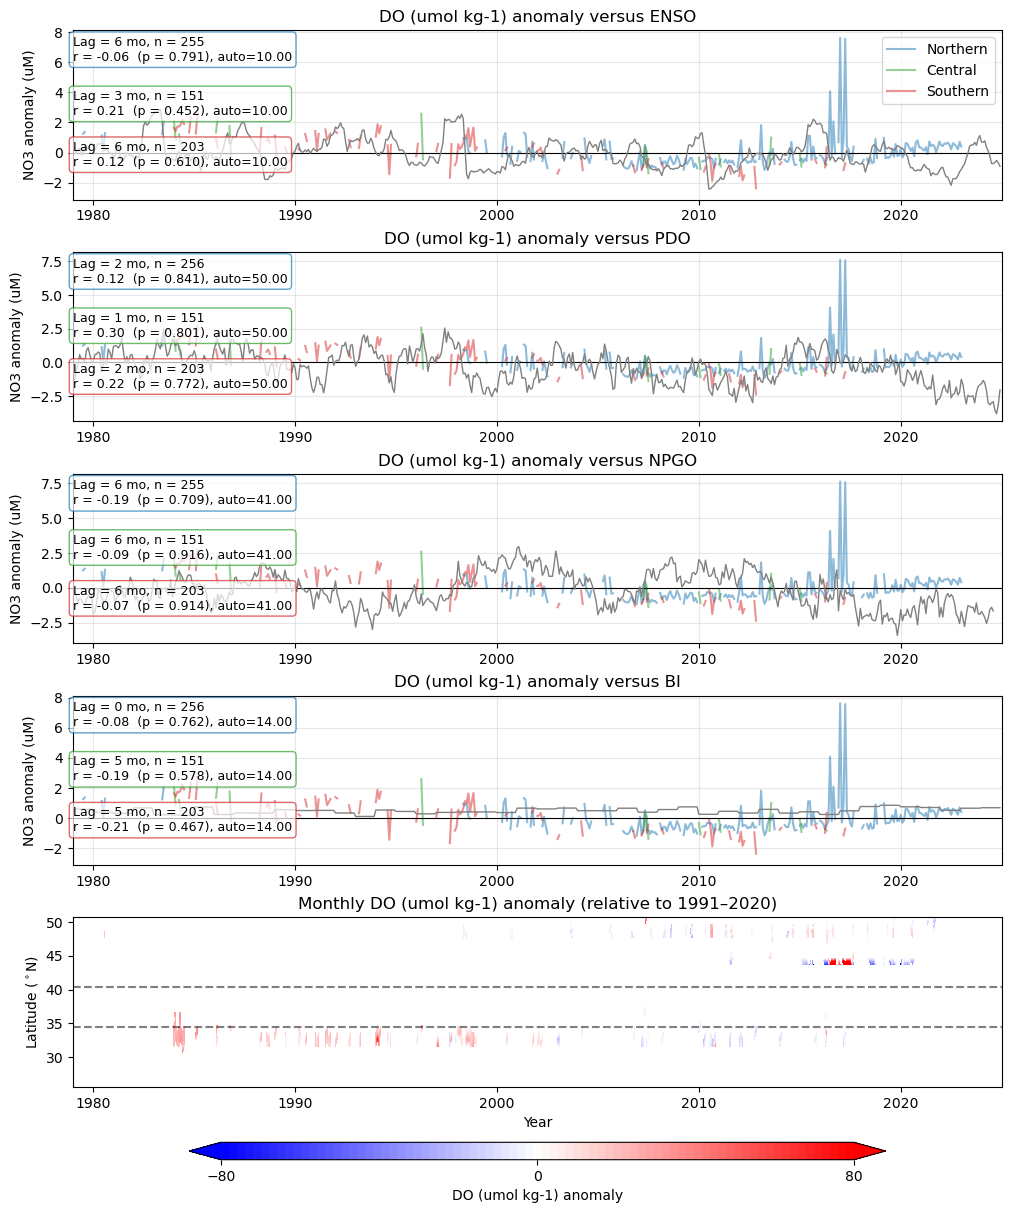

In [36]:
obs_used = obs_cuc.copy()
variable_str = 'DO (umol kg-1)'
showcorrelation(obs_used,variable_str,vmax=80)

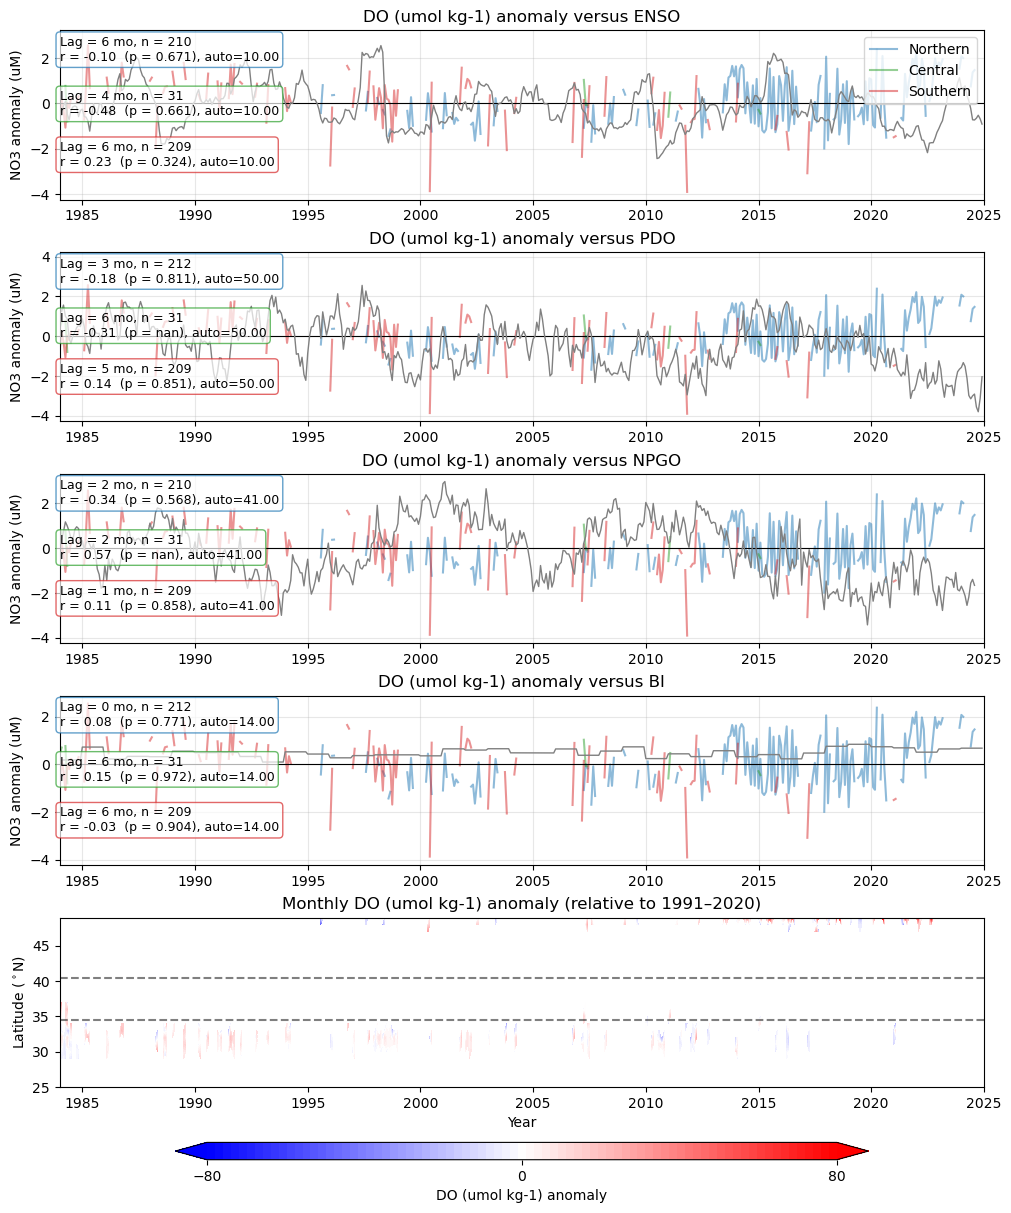

In [37]:
obs_used = obs_cc.copy()
variable_str = 'DO (umol kg-1)'
showcorrelation(obs_used,variable_str,vmax=80)

### NO3

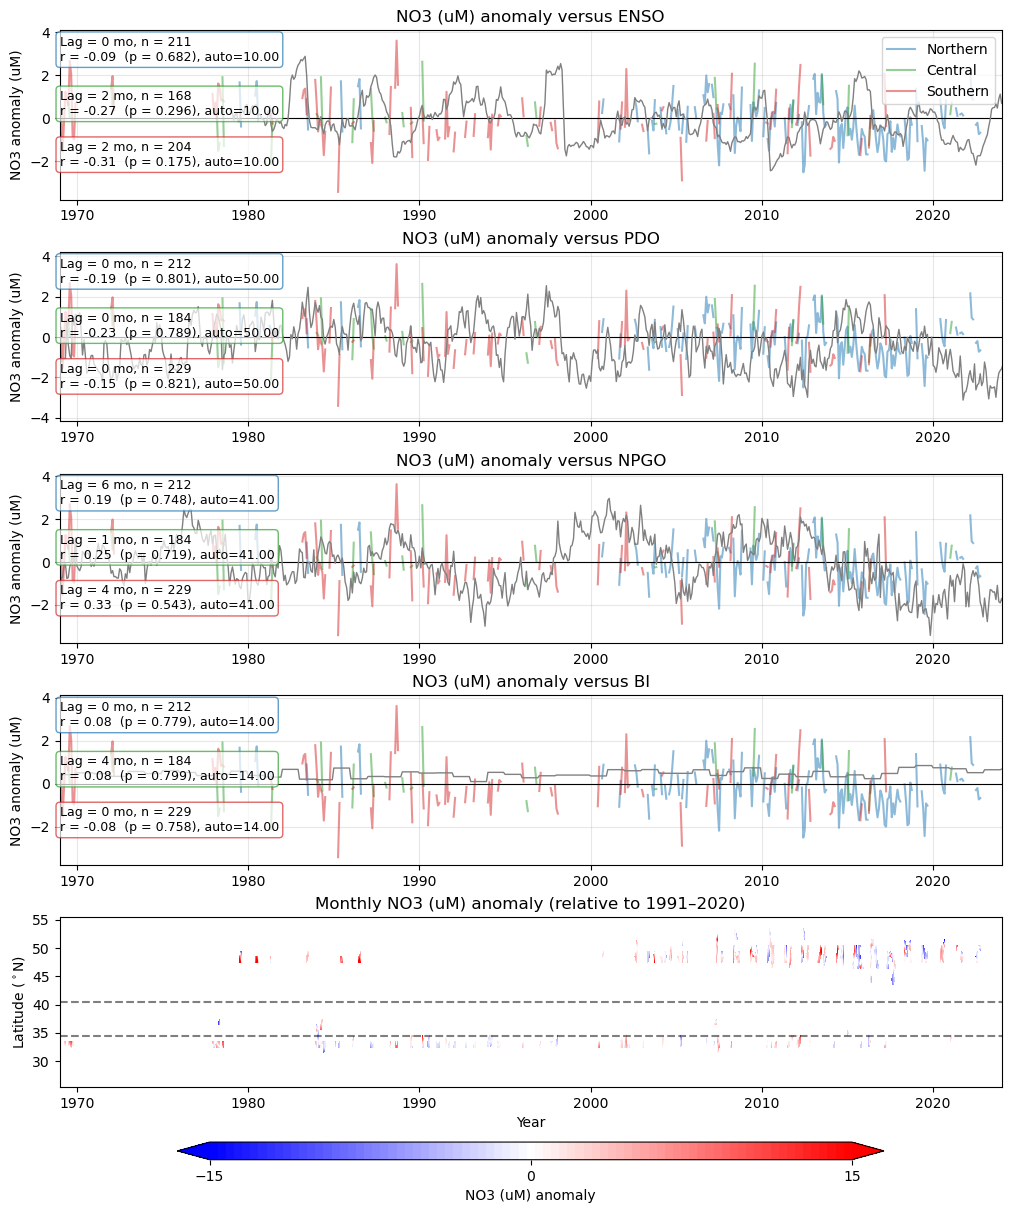

In [38]:
obs_used = obs_shelf.copy()
variable_str = 'NO3 (uM)'
showcorrelation(obs_used,variable_str,vmax=15)

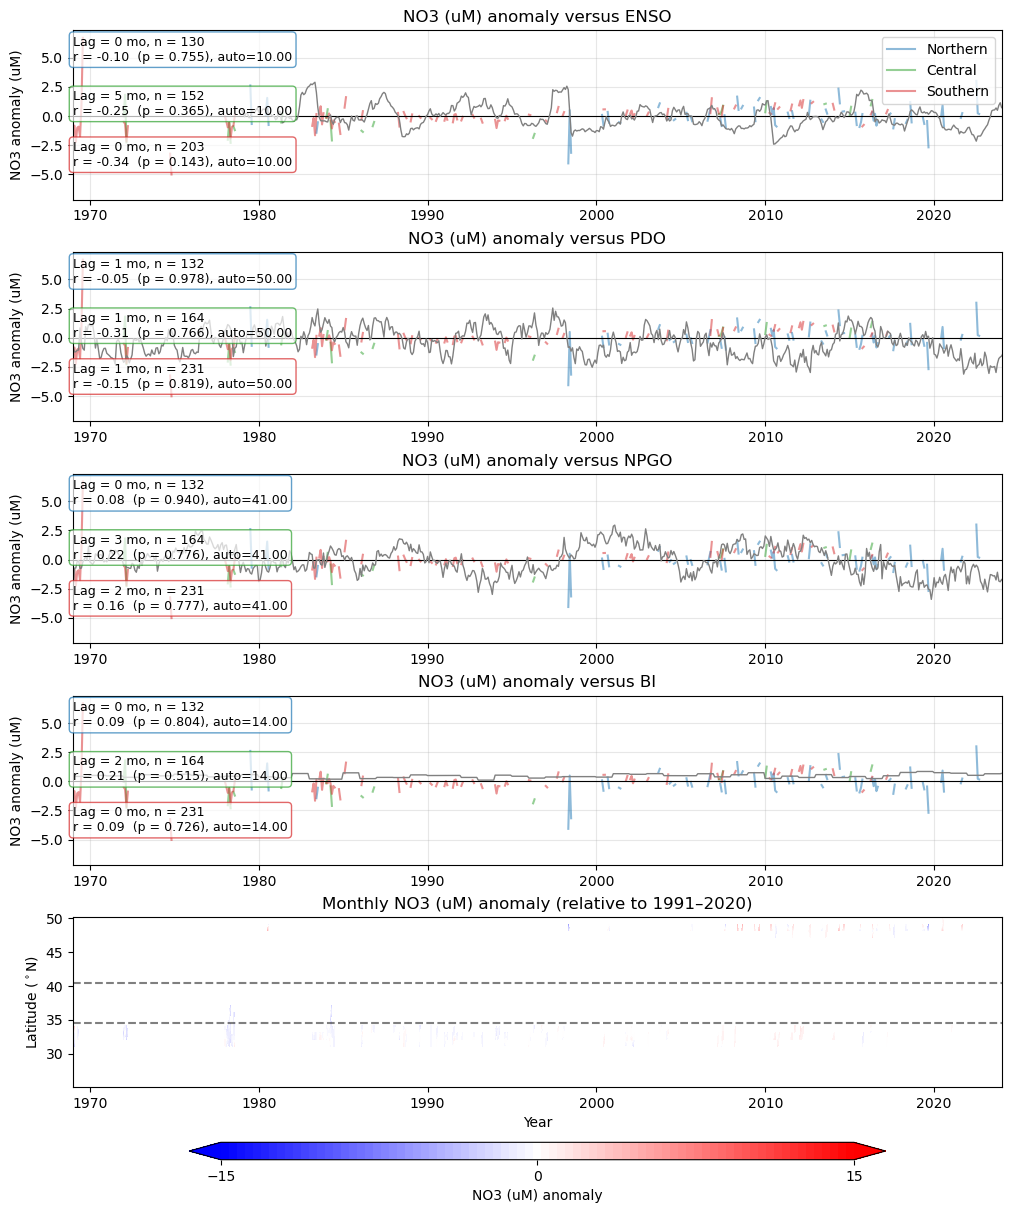

In [39]:
obs_used = obs_cuc.copy()
variable_str = 'NO3 (uM)'
showcorrelation(obs_used,variable_str,vmax=15)

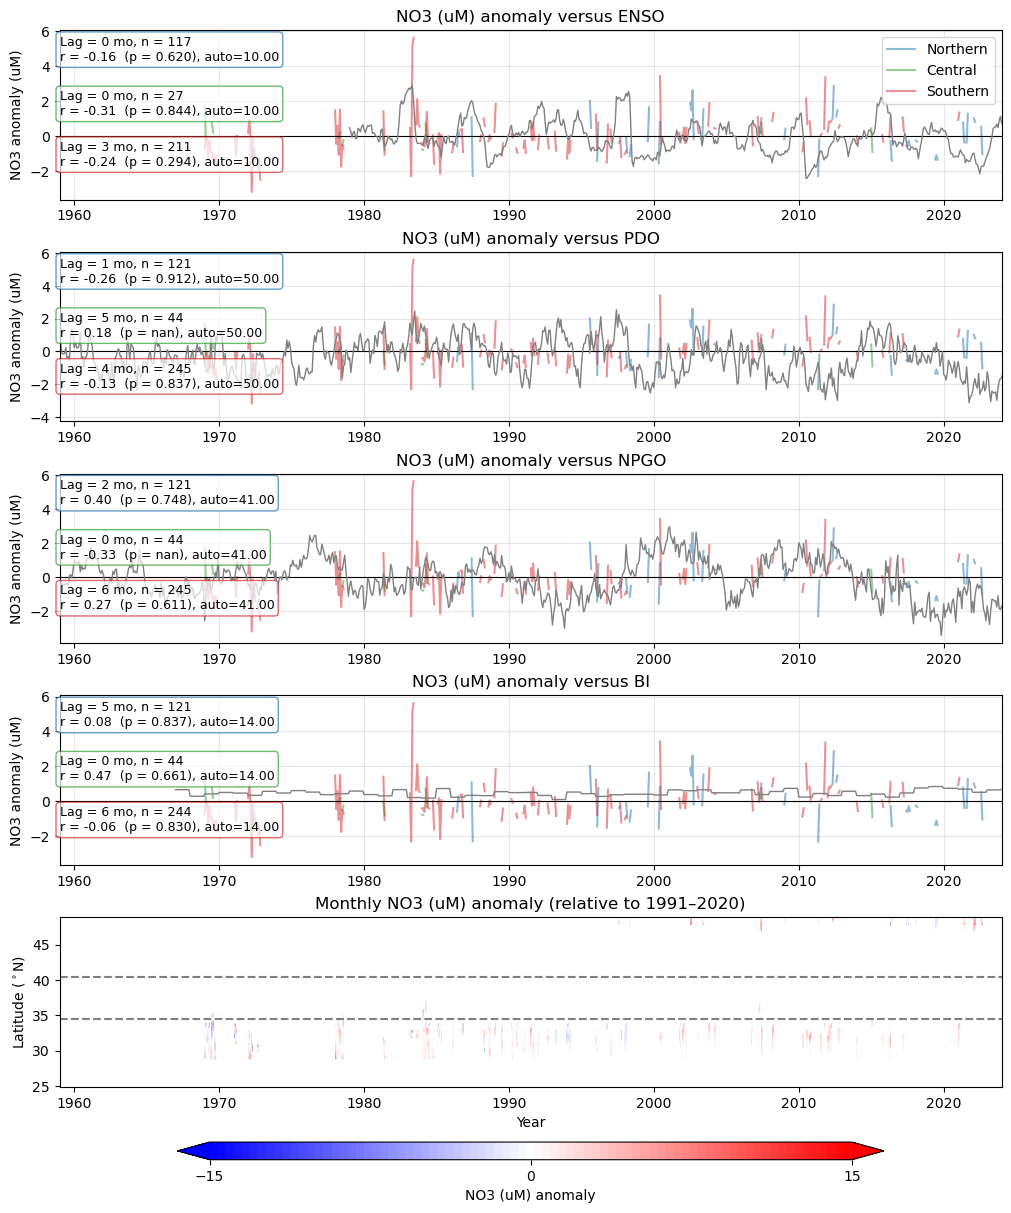

In [40]:
obs_used = obs_cc.copy()
variable_str = 'NO3 (uM)'
showcorrelation(obs_used,variable_str,vmax=15)

## CC split

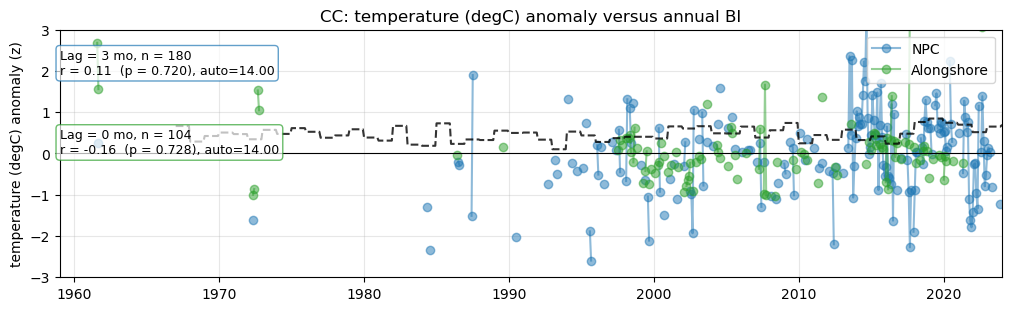

In [41]:
obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'

dist_edges = [np.min(obs_cc.dist),0,700]

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3,usedist=True
)

L0= ACF_lag(anom_array[0],t_month)
L1= ACF_lag(anom_array[1],t_month)

# ---------- plot ----------
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)

ax.plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:blue',marker='o', lw=1.5,alpha=0.5, label='NPC') # zscore converts the anom to a -1-1 variation based on std above and below mean
ax.plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green',marker='o', lw=1.5,alpha=0.5, label='Alongshore')

ax.plot(bi.decimal_yr,bi['index'],'k--',alpha=0.8)

plot_panel(ax, anom_array[0], bi,t_month,L0,Lbi,max_lag_months=6,colour='tab:blue')
plot_panel(ax, anom_array[1], bi,t_month,L1,Lbi,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)


ax.axhline(0, color='k', lw=0.8)
ax.grid(True, alpha=0.3)
ax.set_xlim(start_yr, end_yr + 1)
ax.set_ylim(-3,3)
ax.set_ylabel(f'{variable_str} anomaly (z)')
ax.set_title(f"CC: {variable_str} anomaly versus annual BI")

ax.legend(loc='upper right')

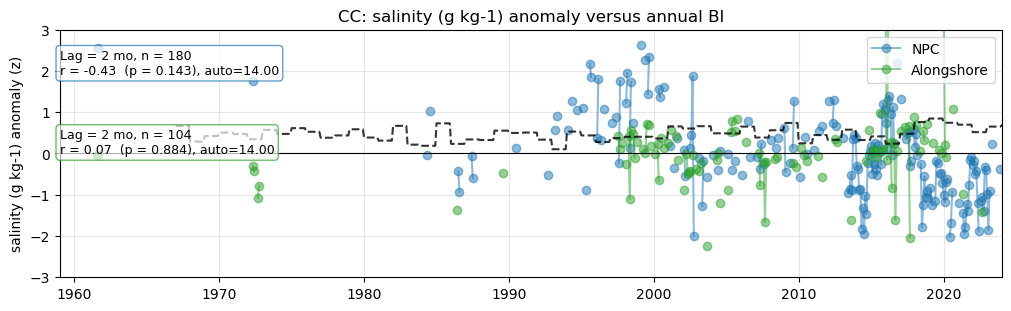

In [42]:
obs_used = obs_cc.copy()
variable_str = 'salinity (g kg-1)'

dist_edges = [np.min(obs_cc.dist),0,700]

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3,usedist=True
)

L0= ACF_lag(anom_array[0],t_month)
L1= ACF_lag(anom_array[1],t_month)

# ---------- plot ----------
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)

ax.plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:blue',marker='o', lw=1.5,alpha=0.5, label='NPC') # zscore converts the anom to a -1-1 variation based on std above and below mean
ax.plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green',marker='o', lw=1.5,alpha=0.5, label='Alongshore')

ax.plot(bi.decimal_yr,bi['index'],'k--',alpha=0.8)

plot_panel(ax, anom_array[0], bi,t_month,L0,Lbi,max_lag_months=6,colour='tab:blue')
plot_panel(ax, anom_array[1], bi,t_month,L1,Lbi,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)


ax.axhline(0, color='k', lw=0.8)
ax.grid(True, alpha=0.3)
ax.set_xlim(start_yr, end_yr + 1)
ax.set_ylim(-3,3)
ax.set_ylabel(f'{variable_str} anomaly (z)')
ax.set_title(f"CC: {variable_str} anomaly versus annual BI")

ax.legend(loc='upper right')